In [1]:
from jax.config import config

config.update("jax_enable_x64", True)

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

/tmp/ipykernel_37567/627097554.py:1: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [2]:
# Install JoviSpec
# git clone https://github.com/HajimeKawahara/jovispec.git
# python setup.py install

from decimal import Decimal
from jovispec import abcio
import pkg_resources


jupiter_data = pkg_resources.resource_filename("jovispec", "jupiter_data")

#red 
rlambc, rspecc, rheadc=abcio.read_qfits("06033",jupiter_data,ext="q")
rlambw, rspecw, rheadw=abcio.read_qfits("06047",jupiter_data,ext="q")
rlambe, rspece, rheade=abcio.read_qfits("06049",jupiter_data,ext="q")

#rapid rotator
rlamb_ref, rspec_ref, rhead_ref = abcio.read_qfits("06031", jupiter_data, ext="q")  # HD13041


#blue
#rlambc, rspecc, rheadc=abcio.read_qfits("06034",jupiter_data,ext="q")
#rlambw, rspecw, rheaadw=abcio.read_qfits("06048",jupiter_data,ext="q")
#rlambe, rspece, rheade=abcio.read_qfits("06050",jupiter_data,ext="q")

In [3]:
wavelength_start = 8500.0 #AA
wavelength_end = 8800.0 #AA

Almost no telluric lines in this wavelength range

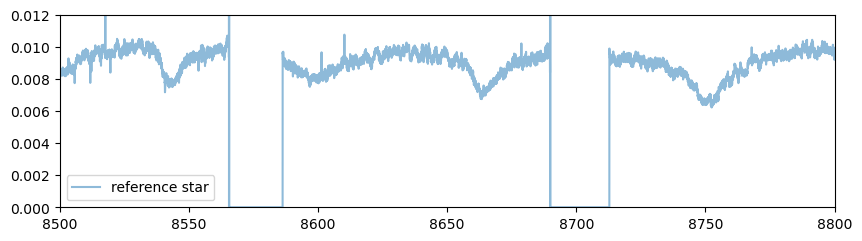

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,2.5))
ax = fig.add_subplot(111)
plt.plot(rlamb_ref,rspec_ref,alpha=0.5,label="reference star")
plt.ylim(0.0,0.012)
plt.xlim(wavelength_start,wavelength_end)
plt.legend()

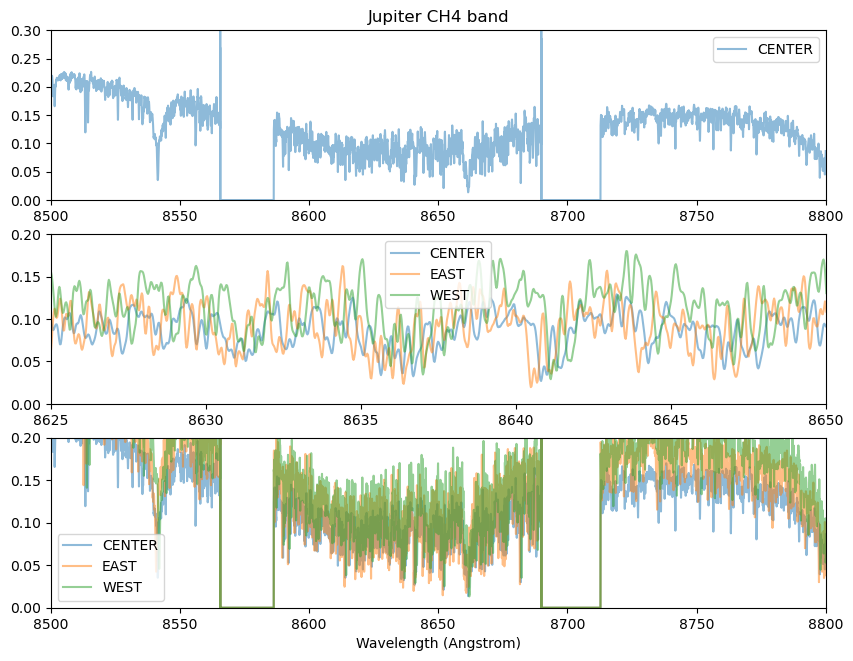

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(311)
plt.plot(rlambc,rspecc,alpha=0.5,label="CENTER")
#plt.plot(rlambe,rspece,alpha=0.5,label="EAST")
#plt.plot(rlambw,rspecw*0.7,alpha=0.5,label="WEST")
plt.ylim(0.0,0.3)
plt.xlim(wavelength_start,wavelength_end)
plt.legend()
plt.title("Jupiter CH4 band")

#plt.xlim(7150.0,7200.0)
ax = fig.add_subplot(312)
plt.plot(rlambc,rspecc,alpha=0.5,label="CENTER")
plt.plot(rlambe,rspece,alpha=0.5,label="EAST")
plt.plot(rlambw,rspecw*0.7,alpha=0.5,label="WEST")
plt.legend()
plt.ylim(0.0,0.2)
plt.xlim(wavelength_start,wavelength_end)
plt.xlim(8625,8650)

ax = fig.add_subplot(313)
plt.plot(rlambc,rspecc,alpha=0.5,label="CENTER")
plt.plot(rlambe,rspece,alpha=0.5,label="EAST")
plt.plot(rlambw,rspecw*0.7,alpha=0.5,label="WEST")
plt.legend()
plt.ylim(0.0,0.2)
plt.xlim(wavelength_start,wavelength_end)

plt.xlabel("Wavelength (Angstrom)")

plt.savefig("ch4jupiter.png")

In [6]:
import numpy as np

rlamb = rlambc
rspec = rspecc

# mask some bad regions... as usual in astronomy  
mask_wav = [
[8565.4, 8586.5],
[8689.5, 8713.0]
]
rlamb = np.array([float(d) for d in rlamb])
mask_index=np.digitize(mask_wav,rlamb)
for ind in mask_index:
    rspec[ind[0]:ind[1]+1] = None


# None for outside wvelength start - end region
start_index=np.digitize(wavelength_start,rlamb)
end_index=np.digitize(wavelength_end,rlamb)
rspec[:start_index] = None
rspec[end_index:] = None

#Air-Vaccum correction
from specutils.utils.wcs_utils import refraction_index
import astropy.units as u
mask = rspec == rspec
rlamb = rlamb[mask]
rspec = rspec[mask]
nair = refraction_index(rlamb*u.AA,method="Ciddor1996")
rlamb = rlamb*nair

# ascending wavenumber form
from exojax.spec.unitconvert import wav2nu
rlamb = rlamb[::-1]
nus_obs = wav2nu(rlamb, unit="AA")
rspec = rspec[::-1]


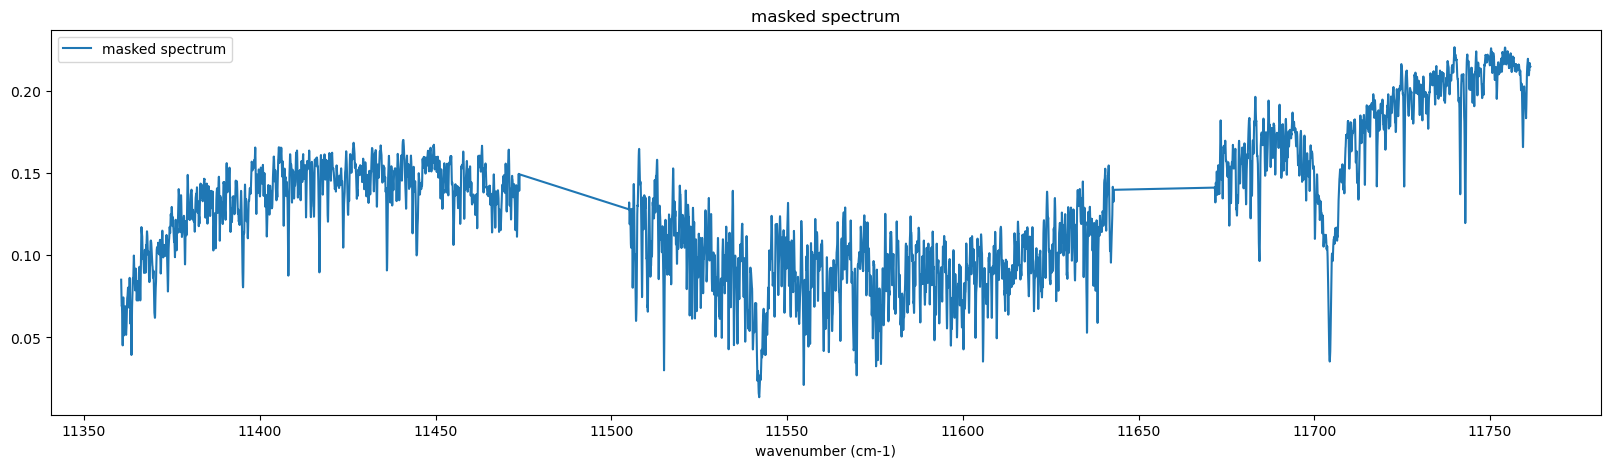

In [7]:
fig = plt.figure(figsize=(20,5))
plt.plot(nus_obs,rspec, label="masked spectrum")
plt.xlabel("wavenumber (cm-1)")
plt.legend()
plt.title("masked spectrum")
plt.show()

### Telluric

In [8]:
from exojax.spec.api import MdbHitran
from exojax.spec.opacalc import OpaDirect
from exojax.spec.opacalc import OpaPremodit
from exojax.utils.grids import wavenumber_grid
from exojax.spec.unitconvert import wav2nu

N = 40000

margin = 10  # cm-1
nus_start = wav2nu(wavelength_end, unit="AA") - margin
nus_end = wav2nu(wavelength_start, unit="AA") + margin
#nus_start = 1.e8/wavelength_end - margin
#nus_end = 1.e8/wavelength_start + margin

mdb_water = MdbHitran("H2O", nurange=[nus_start, nus_end], isotope=1)
nus, wav, res = wavenumber_grid(nus_start, nus_end, N, xsmode="lpf", unit="cm-1")
# opa = OpaDirect(mdb_water, nu_grid=nus)
opa_telluric = OpaPremodit(mdb_water, nu_grid=nus, allow_32bit=True, auto_trange=[150.0, 300.0])

xsmode =  lpf
xsmode assumes ESLOG in wavenumber space: mode=lpf
The wavenumber grid should be in ascending order.
The users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  descending  *** order
OpaPremodit: params automatically set.
Robust range: 148.362692491353 - 337.48243799560873 K
Change the reference temperature from 296.0K to 163.08464046497667 K.


/home/exoplanet01/exojax/src/exojax/spec/set_ditgrid.py:52: UserWarning: There exists negative or zero value.
  warnings.warn("There exists negative or zero value.")


OpaPremodit: Tref_broadening is set to  212.1320343559642 K
OpaPremodit: gamma_air and n_air are used. gamma_ref = gamma_air/Patm
# of reference width grid :  21
# of temperature exponent grid : 4


uniqidx: 100%|██████████| 28/28 [00:00<00:00, 10997.33it/s]


Premodit: Twt= 282.92333337743037 K Tref= 163.08464046497667 K
Making LSD:|####################| 100%


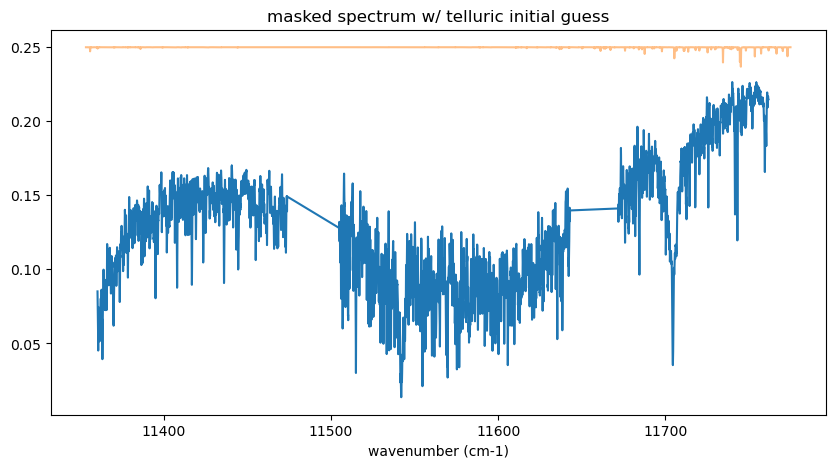

In [9]:
import jax.numpy as jnp

T = 200.0
P = 0.5
xsv = opa_telluric.xsvector(T, P)
nl = 1.0e22
a = 0.25

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
plt.title("masked spectrum w/ telluric initial guess")
plt.plot(nus_obs, rspec)
#plt.ylim(0.0, 0.7)
plt.plot(nus, a * jnp.exp(-nl * xsv), alpha=0.5)
# plt.xlim(1.e8/wavelength_start, 1.e8/wavelength_end)
plt.xlabel("wavenumber (cm-1)")

plt.show()

## Solar spectrum

In [10]:
# high-resolution solar spectrum taken from Meftar et al. (2023) 
# 10.21413/SOLAR-HRS-DATASET.V1.1_LATMOS
# http://doi.latmos.ipsl.fr/DOI_SOLAR_HRS.v1.1.html
# http://bdap.ipsl.fr/voscat_en/solarspectra.html

import pandas as pd
#filename = "/home/kawahara/solar-hrs/Spectre_HR_LATMOS_Meftah_V1.txt"
filename = "/home/exoplanet01/solar-hrs/Spectre_HR_LATMOS_Meftah_V1.txt"
dat = pd.read_csv(filename, names=("wav","flux"), comment=";", delimiter="\t")
dat["wav"] = dat["wav"]*10

wav_solar = dat["wav"][::-1]
solspec = dat["flux"][::-1]
nus_solar = wav2nu(wav_solar,unit="AA")


Text(0.5, 0, 'wavenumber (cm-1)')

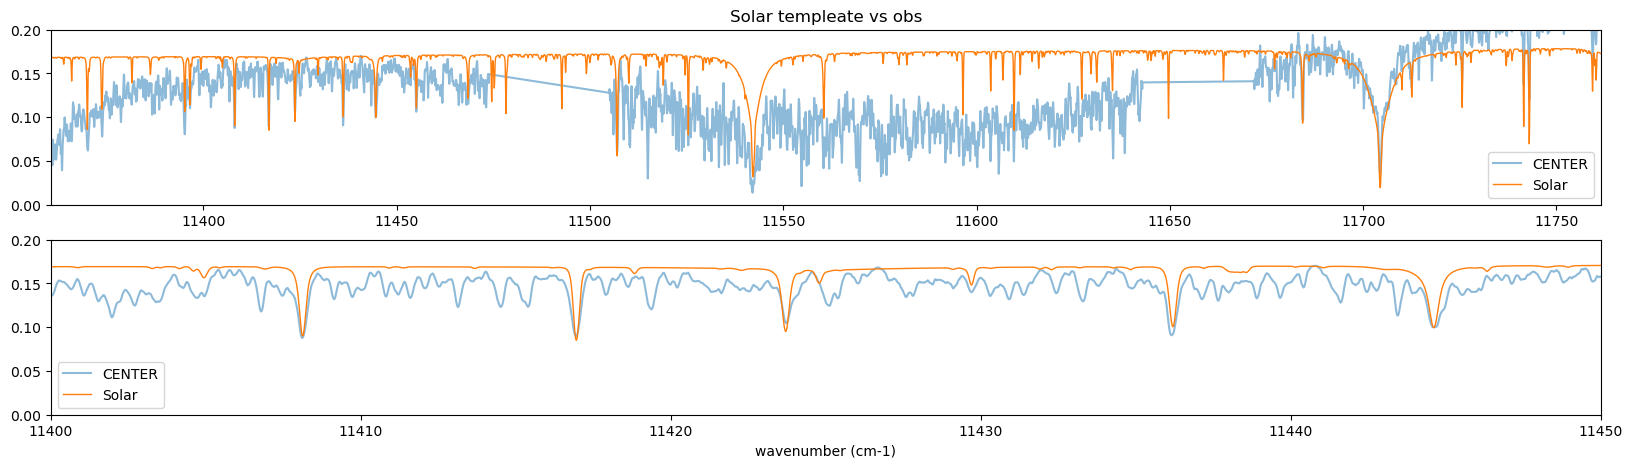

In [11]:
vperc = (106.5-82.5)/300000

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(211)
plt.plot(nus_obs,rspec,alpha=0.5,label="CENTER")
plt.plot(nus_solar*(1.0+vperc),solspec*0.17,lw=1,label="Solar")
plt.xlim(np.min(nus_obs),np.max(nus_obs))
plt.ylim(0.0,0.2)

plt.legend()
plt.title("Solar templeate vs obs")
ax = fig.add_subplot(212)
plt.plot(nus_obs,rspec,alpha=0.5,label="CENTER")
plt.plot(nus_solar*(1.0+vperc),solspec*0.17,lw=1,label="Solar")
plt.xlim(11400,11450)
plt.ylim(0.0,0.2)
plt.legend()
plt.xlabel("wavenumber (cm-1)")


## Model Setting

/home/exoplanet01/exojax/src/exojax/spec/dtau_mmwl.py:14: FutureWarning: dtau_mmwl might be removed in future.
  warnings.warn("dtau_mmwl might be removed in future.", FutureWarning)


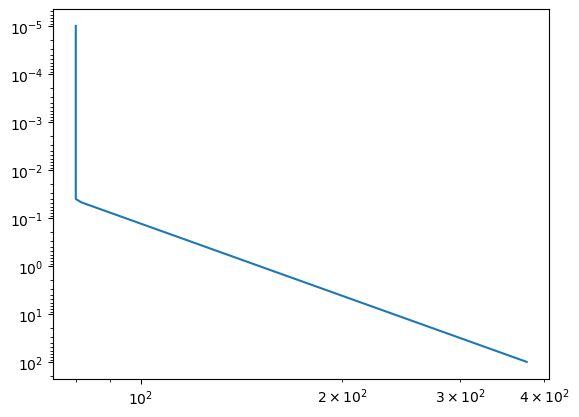

In [12]:
from exojax.spec.atmrt import ArtReflectPure

art = ArtReflectPure(nu_grid=nus, pressure_btm=1.e2, pressure_top=1.e-5, nlayer=100)
art.change_temperature_range(80.0, 500.0)
Tarr = art.powerlaw_temperature(150.0,0.2)
mmr_profile = art.constant_mmr_profile(0.01)

fig= plt.figure()
ax = fig.add_subplot()
ax.plot(Tarr,art.pressure)
ax.invert_yaxis()
plt.yscale("log")
plt.xscale("log")
plt.show()

In [13]:
from exojax.spec.pardb import PdbCloud
from exojax.atm.atmphys import AmpAmcloud

pdb_nh3 = PdbCloud("NH3")
pdb_nh3.load_miegrid()

amp_nh3 = AmpAmcloud(pdb_nh3, bkgatm="H2")
amp_nh3.check_temperature_range(Tarr)

fsed = 1.0
sigmag = 2.0
Kzz = 1.0e4
VMR = 1.0e-4

mu = 2.0  # mean molecular weight
# R = kB / (mu * m_u)
# rho = Parr / (R * Tarr)
from exojax.utils.astrofunc import gravity_jupiter

g = gravity_jupiter(1.0, 1.0)

rg_layer, VMRc = amp_nh3.calc_ammodel(
    art.pressure, Tarr, mu, g, fsed=fsed, sigmag=sigmag, Kzz=Kzz, VMR=VMR
)

.database/particulates/virga/virga.zip  exists. Remove it if you wanna re-download and unzip.
Refractive index file found:  .database/particulates/virga/NH3.refrind
Miegrid file exists: .database/particulates/virga/miegrid_lognorm_NH3.mg.npz
pdb.miegrid, pdb.rg_arr, pdb.sigmag_arr are now available. The Mie scattering computation is ready.


/home/exoplanet01/exojax/src/exojax/atm/atmphys.py:49: UserWarning: min temperature 80.0 K is smaller than min(vfactor t range) 179.10000000000002 K
  warnings.warn(


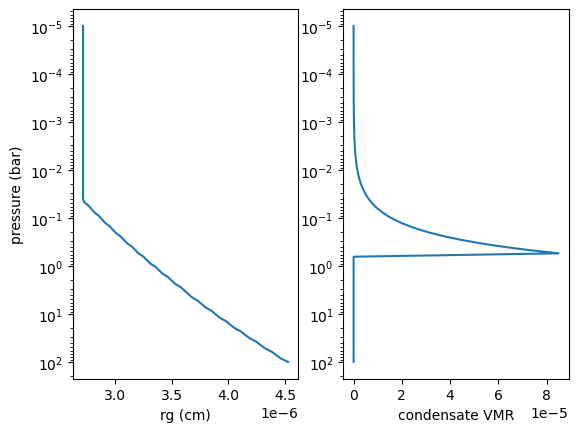

In [14]:
import matplotlib.pyplot as plt

Parr = art.pressure

fig = plt.figure()
ax = fig.add_subplot(121)
plt.plot(rg_layer, Parr)
plt.xlabel("rg (cm)")
plt.ylabel("pressure (bar)")
plt.yscale("log")
ax.invert_yaxis()
ax = fig.add_subplot(122)
plt.plot(VMRc, Parr)
plt.xlabel("condensate VMR")
plt.yscale("log")
# plt.xscale("log")
ax.invert_yaxis()

In [15]:
from exojax.spec.api import MdbHitemp
nu_start = 11353.636363636364
nu_end = 11774.70588235294
mdb = MdbHitemp("CH4", nurange=[nus_start,nus_end], elower_max=4000.0)
mdb.change_reference_temperature(100.0)
#mdb_hitran = MdbHitran("CH4", nurange=[10000.0, 15000.0], isotope=1)


AttributeError: 'DataFrameLocal' object has no attribute 'elower'

In [16]:
nus_start,nus_end

(11353.636363636364, 11774.70588235294)

In [ ]:
#from exojax.spec.optgrid import optelower
#Tmax = 500.0
#Pmin = 1.e-5
#Eopt = optelower(mdb, nus, Tmax, Pmin, isotope=1)
#print(Eopt)

Maximum Elower =  9647.1145
OpaPremodit: initialization without parameters setting
Call self.apply_params() to complete the setting.
OpaPremodit: params manually set.
Change the reference temperature from 296.0K to 296.0 K.
OpaPremodit: Tref_broadening is set to  384.7076812334268 K
OpaPremodit: gamma_air and n_air are used. gamma_ref = gamma_air/Patm
# of reference width grid :  5
# of temperature exponent grid : 2


uniqidx: 100%|██████████| 3/3 [00:00<00:00, 79.88it/s]


Premodit: Twt= 500.0 K Tref= 296.0 K
Making LSD:|####################| 100%


opt Emax:  59%|█████▉    | 58/98 [00:00<00:00, 86.35it/s]

4000.0


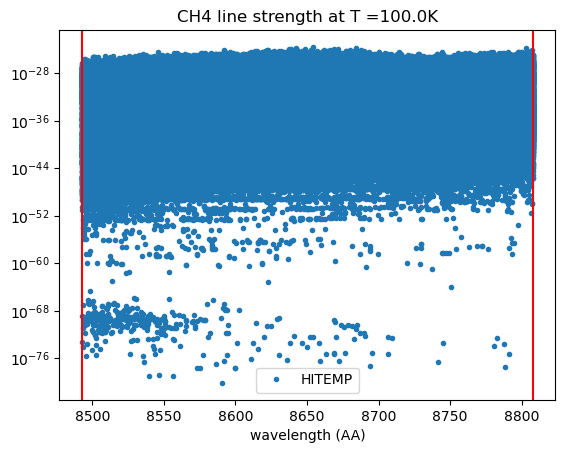

In [ ]:

plt.plot(1.e8/mdb.nu_lines, mdb.line_strength_ref,".",label="HITEMP")
#plt.plot(1.e8/mdb_hitran.nu_lines, mdb_hitran.line_strength_ref,".",label="HITRAN")
plt.axvline(1.e8/nus_start, color="red")
plt.axvline(1.e8/nus_end, color="red")
plt.title("CH4 line strength at T ="+str(mdb.Tref)+"K")
plt.xlabel("wavelength (AA)")
plt.legend()
plt.yscale("log")
plt.savefig("ch4lines.png")

Text(0, 0.5, 'line strength at T=100.0K')

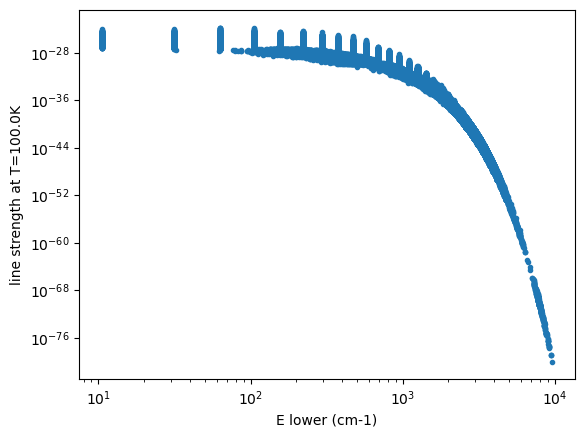

In [ ]:
plt.plot(mdb.elower,mdb.line_strength_ref,".")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("E lower (cm-1)")
plt.ylabel("line strength at T="+str(mdb.Tref)+"K")

In [ ]:
opa = OpaPremodit(mdb, nu_grid=nus, allow_32bit=True, auto_trange=[80.0, 300.0])

OpaPremodit: params automatically set.
Change the reference temperature from 100.0K to None K.


/home/exoplanet01/exojax/src/exojax/spec/lbderror.py:294: UserWarning: Couldn't find the params.
  warnings.warn("Couldn't find the params.")


TypeError: interp requires ndarray or scalar arguments, got <class 'NoneType'> at position 0.